**TODO :**
- Recheck Augmentations
- Recheck LAB normalization
- sampler for faster convergence ?

In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

### Initialization

### Imports

In [2]:
import os
import sys
import torch
import warnings
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
sys.path.append("../code/")
# os.environ['CUDA_VISIBLE_DEVICES'] = "1,0"
warnings.simplefilter("ignore", UserWarning)

In [3]:
from training.main import k_fold

from utils.logger import (
    prepare_log_folder,
    save_config,
    create_logger,
    update_overall_logs,
)

from params import *

### Load

In [4]:
df_info = pd.read_csv(DATA_PATH + f"HuBMAP-20-dataset_information.csv")
df_mask = pd.read_csv(DATA_PATH + "train.csv")

In [5]:
log_folder = "../logs/2021-04-05/4/"  # b1

In [6]:
SIZE = 192

In [7]:
SAVE_DIR = "../logs/2021-04-05/4/boxes_1/"

### Dataset

In [8]:
from data.transforms import HE_preprocess_cls
from data.dataset import TileClsDataset

In [22]:
images = df_mask['id'].values.tolist()
# images = [img for j, img in enumerate(images) if (j % 5) == 0]

dataset = TileClsDataset(images, SAVE_DIR, transforms=HE_preprocess_cls(visualize=True, size=128))

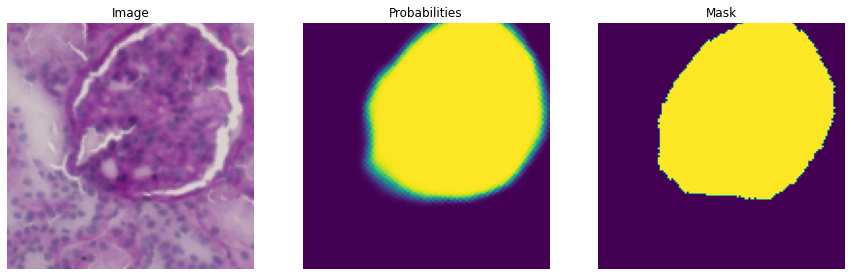

In [23]:
img, mask, y = dataset[0]
print(f'Target : {int(y)} - max prob : {img[-1].max()}')

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img.numpy().transpose(1, 2, 0)[:, :, :3])
plt.axis(False)
plt.title('Image')

plt.subplot(1, 3, 2)
plt.imshow(img.numpy().transpose(1, 2, 0)[:, :, -1])
plt.axis(False)
plt.title('Probabilities')

plt.subplot(1, 3, 3)
plt.imshow(mask.numpy())
plt.axis(False)
plt.title('Mask')
plt.show()

In [24]:
preds = []
truths = []
for i in tqdm(range(len(dataset))):
    img, mask, y = dataset[i]
    truths.append(y)
    
    prob = img[-1].numpy()
    preds.append(prob[64, 64] > 0.4)    

In [25]:
accuracy_score(truths, np.array(preds))

0.9296194976374036

## Model

In [13]:
from model_zoo.models_cls import define_model_cls

In [14]:
cp_path = "../logs/2021-04-05/4/" + "Unet_efficientnet-b1_0.pt"
model = define_model_cls('Unet', 'efficientnet-b1', cp_path=cp_path, in_channels=4)


 -> Loading weights from ../logs/2021-04-05/4/Unet_efficientnet-b1_0.pt



In [15]:
model(torch.rand(1, 4, 128, 128))

tensor([[-0.0746]], grad_fn=<AddmmBackward>)

## Fit

In [16]:
import time
import torch
import numpy as np  # noqa

from torchcontrib.optim import SWA
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from transformers import get_linear_schedule_with_warmup


from params import NUM_WORKERS
from training.optim import define_loss, define_optimizer, prepare_for_loss


def fit_cls(
    model,
    train_dataset,
    val_dataset,
    optimizer_name="Adam",
    loss_name="BCEWithLogitsLoss",
    activation="sigmoid",
    epochs=50,
    batch_size=32,
    val_bs=32,
    warmup_prop=0.1,
    lr=1e-3,
    swa_first_epoch=50,
    verbose=1,
    first_epoch_eval=0,
    device="cuda",
    use_fp16=False,
):
    """
    Usual torch fit function.

    Args:
        model (torch model): Model to train.
        train_dataset (torch dataset): Dataset to train with.
        optimizer_name (str, optional): Optimizer name. Defaults to 'adam'.
        loss_name (str, optional): Loss name. Defaults to 'BCEWithLogitsLoss'.
        activation (str, optional): Activation function. Defaults to 'sigmoid'.
        epochs (int, optional): Number of epochs. Defaults to 50.
        batch_size (int, optional): Training batch size. Defaults to 32.
        val_bs (int, optional): Validation batch size. Defaults to 32.
        warmup_prop (float, optional): Warmup proportion. Defaults to 0.1.
        lr (float, optional): Learning rate. Defaults to 1e-3.
        swa_first_epoch (int, optional): Epoch to start applying SWA from. Defaults to 50.
        verbose (int, optional): Period (in epochs) to display logs at. Defaults to 1.
        first_epoch_eval (int, optional): Epoch to start evaluating at. Defaults to 0.
        device (str, optional): Device for torch. Defaults to "cuda".
        use_fp16 (bool, optional): Whether to use mixed precision. Defaults to False.

    Returns:
        numpy array [len(val_dataset) x num_classes]: Last prediction on the validation data.
        pandas dataframe: Training history.
    """

    avg_val_loss = 0.0
    history = None

    if use_fp16:
        scaler = torch.cuda.amp.GradScaler()

    optimizer = define_optimizer(optimizer_name, model.parameters(), lr=lr)
    if swa_first_epoch <= epochs:
        optimizer = SWA(optimizer)

    loss_fct = define_loss(loss_name, device=device)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        drop_last=True,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=val_bs,
        drop_last=False,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=True
    )

    num_warmup_steps = int(warmup_prop * epochs * len(train_loader))
    num_training_steps = int(epochs * len(train_loader))
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps, num_training_steps
    )

    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        optimizer.zero_grad()
        avg_loss = 0

        if epoch + 1 > swa_first_epoch:
            optimizer.swap_swa_sgd()

        for batch in train_loader:
            x = batch[0].to(device).float()
            y_batch = batch[2].float()

            if use_fp16:
                with torch.cuda.amp.autocast():
                    y_pred = model(x)

                    y_pred, y_batch = prepare_for_loss(y_pred, y_batch, loss_name, device=device)

                    loss = loss_fct(y_pred, y_batch).mean()

                    scaler.scale(loss).backward()

                    avg_loss += loss.item() / len(train_loader)

                    scaler.step(optimizer)
                    scaler.update()
            else:
                y_pred = model(x)

                y_pred, y_batch = prepare_for_loss(y_pred, y_batch, loss_name, device=device)
                loss = loss_fct(y_pred, y_batch).mean()

                loss.backward()
                avg_loss += loss.item() / len(train_loader)

                optimizer.step()

            scheduler.step()
            for param in model.parameters():
                param.grad = None

        if epoch + 1 >= swa_first_epoch:
            optimizer.update_swa()
            optimizer.swap_swa_sgd()

        model.eval()
        avg_val_loss = 0.
        preds, truths = [], []

        if epoch + 1 >= first_epoch_eval:
            with torch.no_grad():
                for batch in val_loader:
                    x = batch[0].to(device).float()
                    y_batch = batch[2].float()

                    y_pred = model(x)

                    y_pred, y_batch = prepare_for_loss(
                        y_pred,
                        y_batch,
                        loss_name,
                        device=device,
                        train=False
                    )

                    loss = loss_fct(y_pred, y_batch).mean()
                    avg_val_loss += loss / len(val_loader)

                    if activation == "sigmoid":
                        y_pred = torch.sigmoid(y_pred)
                    elif activation == "softmax":
                        y_pred = torch.softmax(y_pred, 2)

                    preds.append(y_pred.cpu().numpy())
                    truths.append(y_batch.cpu().numpy())

        preds, truths = np.concatenate(preds), np.concatenate(truths)
        acc = accuracy_score(truths, preds > 0.5)
        

        elapsed_time = time.time() - start_time
        if (epoch + 1) % verbose == 0:
            elapsed_time = elapsed_time * verbose
            lr = scheduler.get_last_lr()[0]
            print(
                f"Epoch {epoch + 1:02d}/{epochs:02d} \t lr={lr:.1e}\t t={elapsed_time:.0f}s\t"
                f"loss={avg_loss:.3f}",
                end="\t",
            )
            if epoch + 1 >= first_epoch_eval:
                print(f"val_loss={avg_val_loss:.3f} \t acc={acc:.4f}")
            else:
                print("")

    del val_loader, train_loader, y_pred, loss, x, y_batch
    torch.cuda.empty_cache()
    
    return preds, truths

## Training

In [17]:
import gc
import time
import torch
import numpy as np
import pandas as pd


from params import DATA_PATH
from training.train import fit
from model_zoo.models import define_model
from data.transforms import HE_preprocess
from utils.metrics import tweak_threshold
from training.predict import predict_entire_mask_downscaled
from data.dataset import InMemoryTrainDataset, InferenceDataset
from utils.torch import seed_everything, count_parameters, save_model_weights


def train_cls(config, train_dataset, val_dataset, fold, log_folder=None):
    """
    Trains and validate a model.

    Args:
        config (Config): Parameters.
        dataset (torch Dataset): whole dataset InMemory
        fold (int): Selected fold.
        log_folder (None or str, optional): Folder to logs results to. Defaults to None.

    Returns:
        SegmentationMeter: Meter.
        pandas dataframe: Training history.
    """
    seed_everything(config.seed)

    model = define_model_cls(
        config.decoder,
        config.encoder,
        num_classes=config.num_classes,
        in_channels=config.in_channels,
        cp_path=config.cp_folder + f"{config.decoder}_{config.encoder}_{fold}.pt"
    ).to(config.device)
    model.zero_grad()

    n_parameters = count_parameters(model)

    print(f"    -> {n_parameters} trainable parameters")
    print(f"    -> {len(train_dataset)} training tiles")
    print(f"    -> {len(val_dataset)} validation tiles\n")

    preds, truths = fit_cls(
        model,
        train_dataset,
        val_dataset,
        optimizer_name=config.optimizer,
        loss_name=config.loss,
        activation=config.activation,
        epochs=config.epochs,
        batch_size=config.batch_size,
        val_bs=config.val_bs,
        lr=config.lr,
        warmup_prop=config.warmup_prop,
        swa_first_epoch=config.swa_first_epoch,
        verbose=config.verbose,
        first_epoch_eval=config.first_epoch_eval,
        device=config.device,
        use_fp16=config.use_fp16,
    )

    if config.save_weights and log_folder is not None:
        name = f"{config.encoder}_{fold}.pt"
        save_model_weights(
            model,
            name,
            cp_folder=log_folder,
        )
    del model
    torch.cuda.empty_cache()
    gc.collect()
    
    return preds, truths


def k_fold_cls(config, log_folder=None):
    """
    Performs a patient grouped k-fold cross validation.
    The following things are saved to the log folder : val predictions, histories

    Args:
        config (Config): Parameters.
        log_folder (None or str, optional): Folder to logs results to. Defaults to None.
    """
    scores = []
    images = pd.read_csv(f"../input/train.csv").id.unique()
    
    all_preds, all_truths = [], []

    for i in config.selected_folds:
        print(f"\n-------------   Fold {i + 1} / {config.nb_folds}  -------------\n")
        
        train_images = [img for j, img in enumerate(images) if (j % config.nb_folds) != i]
        val_images = [img for j, img in enumerate(images) if (j % config.nb_folds) == i]
        
        train_dataset = TileClsDataset(
            train_images, 
            config.tile_dir, 
            transforms=HE_preprocess_cls(size=config.tile_size)
        )
        
        val_dataset = TileClsDataset(
            val_images, 
            config.tile_dir, 
            transforms=HE_preprocess_cls(size=config.tile_size, augment=False)
        )

        preds, truths = train_cls(config, train_dataset, val_dataset, i, log_folder=log_folder)
        all_preds.append(preds)
        all_truths.append(truths)
        
    preds = np.concatenate(all_preds)
    truths = np.concatenate(all_truths)
    
    acc = accuracy_score(truths, preds > 0.5)
    print(f'\n -> Accuracy CV : {acc:.4f}')

# Main

In [18]:
BATCH_SIZES = {
    "resnet18": 64,
    "resnet34": 32, 
    "resnext50_32x4d": 32, 
    "se_resnext50_32x4d": 32,
    "efficientnet-b0": 32,
    "efficientnet-b1": 32,
    "efficientnet-b2": 32,
    "efficientnet-b3": 32,
    "efficientnet-b4": 32,
    "efficientnet-b5": 16,
    "efficientnet-b6": 8,
}

In [19]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1
    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True
    
    # Images    
    tile_dir = "../logs/2021-04-05/4/boxes_1/"
    tile_size = 128

    # k-fold
    nb_folds = 5
    selected_folds = [0, 1, 2, 3, 4]

    # Model
    encoder = "efficientnet-b1"  # "resnet18" "resnext50_32x4d", "resnet34", "efficientnet-b5"
    decoder = "Unet"  # "Unet", "DeepLabV3Plus"
    num_classes = 1
    in_channels = 4
    cp_folder = "../logs/2021-04-05/4/"  # b1

    # Training
    loss = "BCEWithLogitsLoss"  # "SoftDiceLoss" / "BCEWithLogitsLoss"  / "lovasz"
    activation = "none" if loss == "lovasz" else "sigmoid"

    optimizer = "Adam"
    
    batch_size = BATCH_SIZES[encoder]
        
    epochs = 15

    lr = 1e-3
    swa_first_epoch = 20

    warmup_prop = 0.05
    val_bs = batch_size * 2

    first_epoch_eval = 0
    
    use_fp16 = True

In [20]:
DEBUG = False
log_folder = None

In [21]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f"Logging results to {log_folder}")
    config_df = save_config(Config, log_folder + "config.json")
    create_logger(directory=log_folder, name="logs.txt")

metrics = k_fold_cls(Config, log_folder=log_folder)

Logging results to ../logs/2021-04-11/2/

-------------   Fold 1 / 5  -------------


 -> Loading weights from ../logs/2021-04-05/4/Unet_efficientnet-b1_0.pt

    -> 6513825 trainable parameters
    -> 3253 training tiles
    -> 768 validation tiles

Epoch 01/15 	 lr=9.8e-04	 t=9s	loss=0.534	val_loss=0.301 	 acc=0.8958
Epoch 02/15 	 lr=9.1e-04	 t=9s	loss=0.272	val_loss=0.482 	 acc=0.8125
Epoch 03/15 	 lr=8.4e-04	 t=9s	loss=0.226	val_loss=0.205 	 acc=0.9271
Epoch 04/15 	 lr=7.7e-04	 t=9s	loss=0.196	val_loss=0.181 	 acc=0.9310
Epoch 05/15 	 lr=7.0e-04	 t=9s	loss=0.196	val_loss=0.181 	 acc=0.9167
Epoch 06/15 	 lr=6.3e-04	 t=9s	loss=0.177	val_loss=0.177 	 acc=0.9167
Epoch 07/15 	 lr=5.6e-04	 t=9s	loss=0.175	val_loss=0.188 	 acc=0.9141
Epoch 08/15 	 lr=4.9e-04	 t=9s	loss=0.165	val_loss=0.167 	 acc=0.9128
Epoch 09/15 	 lr=4.2e-04	 t=9s	loss=0.156	val_loss=0.202 	 acc=0.9258
Epoch 10/15 	 lr=3.5e-04	 t=9s	loss=0.149	val_loss=0.184 	 acc=0.9232
Epoch 11/15 	 lr=2.8e-04	 t=9s	loss=0.137	val_los